# Step 1: Process Data

In [3]:
import pandas as pd
import re
import numpy as np

def loginToHours(L):
    if L[1]=='hours' or L[1]=='hour':
        return int(L[0])
    elif L[1]=='minutes' or L[1]=='minute':
        return 0
    elif L[1]=='days' or L[1]=='day':
        return 24 * int(L[0])
    elif L[1]=='weeks' or L[1]=='week':
        return 7 * 24 * int(L[0])
    elif L[1]=='months' or L[1]=='month':
        return 30 * 24 * int(L[0])
    elif L[1]=='years' or L[1]=='year':
        return 365 * 24 * int(L[0])
    else:
        return 365 * 24 * 15

def renameCountries(country):
    if re.search('usa', country.lower()) or re.search('va', country.lower()) or re.search('californie', country.lower()):
        return "United States"
    elif re.search("united kingdom", country.lower()) or re.search("uk", country.lower()) or re.search("england", country.lower()) or re.search('london', country.lower()):
        return "United Kingdom"
    elif re.search('edinburgh', country.lower()) or re.search('bristol', country.lower()) or re.search('scotland', country.lower()) or re.search('oxfordshire', country.lower()) or re.search('merseyside', country.lower()) or re.search('manchester', country.lower()):
        return "United Kingdom"
    elif re.search('cairo', country.lower()):
        return "Egypt"
    elif re.search('rabat', country.lower()) or re.search('maroc', country.lower()) or re.search('morroco', country.lower()):
        return "Morocco"
    elif re.search('malm', country.lower()):
        return "Sweden"
    elif re.search('tunis', country.lower()):
        return "Tunisia"
    elif re.search('tokyo', country.lower()):
        return "Japan"
    elif re.search('rennes', country.lower()) or re.search('nantes', country.lower()):
        return "France"
    elif re.search('united republic of', country.lower()):
        return "Tanzania"
    elif re.search('korea', country.lower()) or re.search('seoul', country.lower()) or re.search('republic of', country.lower()):
        return "South Korea"
    elif re.search('czechia', country.lower()):
        return "Czech Republic"
    elif re.search('russian federation', country.lower()):
        return "Russia"
    else:
        return country

In [4]:
# Load preliminary data about profiles:
SearchResults = pd.read_csv('profileURLs.csv', header = None)
SearchResults.columns = ['user_url', 'responseSpeed', 'refsandfriends', 'languages', 'couchstatus']

In [5]:
Profiles = pd.read_csv('sofariders/sofarider_profiles.csv', index_col='user_url')
Profiles.drop(index = 'user_url', inplace=True)

In [6]:
CityInfo = pd.read_csv('cityHostNumbers.csv')
#CityInfo.columns = ['nHostsinCity','cityurl', 'city']
CityInfo.head()

,nHosts,CityUrl,City
0,6461,https://www.couchsurfing.com/places/africa/sou...,Johannesburg
1,26719,https://www.couchsurfing.com/places/africa/egy...,Cairo
2,13621,https://www.couchsurfing.com/places/africa/mor...,Marrakesh
3,10453,https://www.couchsurfing.com/places/africa/mor...,Rabat
4,11040,https://www.couchsurfing.com/places/africa/sou...,Cape


In [7]:
# Split data from refsandfriends into multiple columns
SearchResults['refsandfriends'] = list(map(lambda x: x.split('\n'), SearchResults.refsandfriends))
SearchResults['nRefs'] = list(map(lambda x: int(x[0].split(' ')[0]), SearchResults.refsandfriends))
SearchResults['nFriends'] = list(map(lambda x: re.findall("[0-9]+ Friends", str(x)), SearchResults.refsandfriends))
SearchResults['nFriends']  = list(map(lambda x: 0 if x==[] else int(x[0].split(' ')[0]), SearchResults.nFriends))
SearchResults['languages'] = list(map(lambda x: re.sub("Speaks ","", str(x)), SearchResults.languages))
SearchResults['languages'] = list(map(lambda x: str(x).split(", "), SearchResults.languages))
SearchResults['nLanguages'] = list(map(lambda x: 0 if x==['nan'] else len(x), SearchResults.languages))
#SearchResults.drop('refsandfriends', axis=1, inplace=True)

# Add profile data to search result data:

uselessCols = ['friends','preferredGender','maxGuests','lastMinuteOkay','languages', 'refs_fromHosts_neg', 'refs_fromHosts_pos', 'refs_fromSurfers_neg', 'refs_fromSurfers_pos', 'responseRate']
Profiles.drop(uselessCols,axis = 1, inplace=True)
Profiles.profileCompletion = list(map(lambda x: int(re.findall("[0-9]+", x)[0]), Profiles.profileCompletion))
Profiles.joinDate = list(map(lambda x: int(re.findall("[0-9]+", x)[0]), Profiles.joinDate))
Profiles.lastLogin = list(map(lambda x: x.split(" ")[-3:-1], Profiles.lastLogin))
Profiles['hoursSinceLogin'] = list(map(loginToHours, Profiles.lastLogin))
Profiles['currentCountry'] = list(map(lambda x: str(x).split(',')[-1].strip().title(),Profiles.location))
#Profiles.drop(profiles.currentCountry=="Republic Of")
Profiles['currentCity'] = list(map(lambda x: str(x).split(',')[0].title(),Profiles.location))

# Make some minor tweaks for consistency:
Profiles['currentCountry'] = list(map(renameCountries, Profiles.currentCountry))

combined_df = pd.merge(SearchResults, Profiles, how='inner', on = 'user_url')
combined_df = pd.merge(combined_df, CityInfo, how = 'left', left_on='currentCity', right_on='City')

# Remove any duplicate profiles:
print(str(len(combined_df)) + " profiles before dropping duplicates")
combined_df.drop_duplicates(subset = 'user_url', inplace = True)
print(str(len(combined_df)) + " profiles after dropping duplicates")

combined_df.to_csv('ProcessedUserInfo.csv')

50368 profiles before dropping duplicates
49343 profiles after dropping duplicates


# Step 2: Load Processed Data

In [8]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

df = pd.read_csv('ProcessedUserInfo.csv', index_col=0)

In [9]:
# Remove entries for users who can't seem to spell their own country:
df = df.groupby('currentCountry').filter(lambda x: len(x) > 2)

# Set age for users with unreasonable ages to 0:
df.loc[df.age > 122, 'age'] = np.nan

In [10]:
df['joinAge'] = df.age - 2018 + df.joinDate

# Step 3: Start EDA

In [11]:
df.describe()

,nRefs,nFriends,nLanguages,age,joinDate,profileCompletion,hoursSinceLogin,nHosts,joinAge
count,49272.000000,49272.000000,49272.000000,49250.000000,49272.000000,49272.000000,49272.000000,36162.000000,49250.000000
mean,1.151242,3.105415,0.626279,29.386193,2015.447658,34.034239,11006.626969,21727.060340,26.833584
std,8.422688,20.141737,0.829945,9.689933,2.417518,32.231445,14427.206208,29319.464649,9.604352
min,0.000000,0.000000,0.000000,0.000000,2004.000000,5.000000,0.000000,5535.000000,-14.000000
25%,0.000000,0.000000,0.000000,24.000000,2014.000000,10.000000,1440.000000,9196.000000,22.000000
50%,0.000000,0.000000,0.000000,28.000000,2016.000000,15.000000,7200.000000,13619.000000,25.000000
75%,0.000000,1.000000,1.000000,33.000000,2017.000000,60.000000,17520.000000,22664.000000,30.000000
max,980.000000,2171.000000,2.000000,120.000000,2018.000000,100.000000,131400.000000,163012.000000,118.000000


In [12]:
#df.groupby('languages').agg(['mean','count'])

In [13]:
#df.groupby('responseSpeed').agg(['mean','count'])

In [14]:
#df.groupby('responseSpeed').agg(['mean','count'])

## What is the breakdown of the subset of users we have data on?

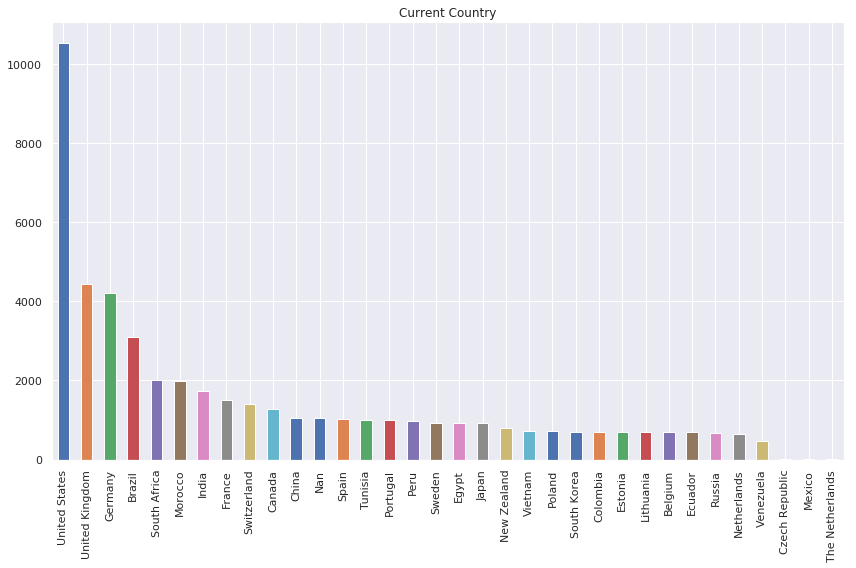

In [15]:
df['currentCountry'].value_counts().plot(kind='bar', figsize = (12,8))
plt.title("Current Country")
#sns.catplot(x='currentCountry', data=df, kind='count', height = 10, color='steelblue')
plt.tight_layout()
plt.savefig('countryBar.png')

58 percent male


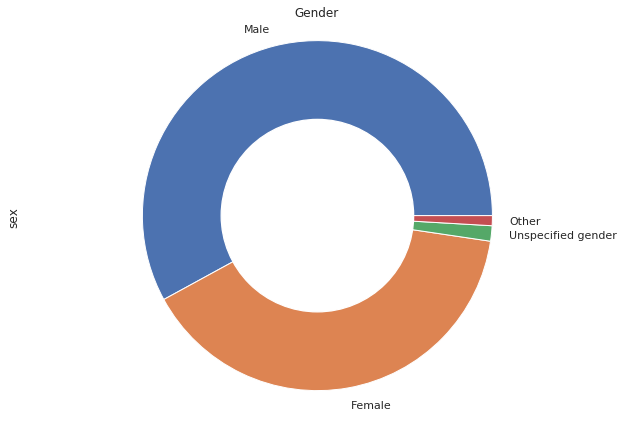

In [37]:
plt.figure(figsize=(8.75,6))

df['sex'].value_counts().plot(kind='pie')
title = plt.title("Gender")
centre_circle = plt.Circle((0,0), 0.55, color='white', fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.tight_layout()

plt.savefig('HostGender.png')

pctMale = 100 * len(df[df.sex=='Male'])/df.shape[0]
print(str(round(pctMale)) + " percent male")

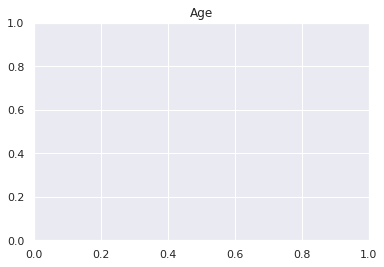

In [17]:
#fig5 = sns.catplot('age',data=df[(df.age<122) & (df.age > 0)], color='steelblue', kind='count', height = 8)
#fig5.xlim = (18,40)
title = plt.title('Age')

Text(0.5,1,'Hours since last login')

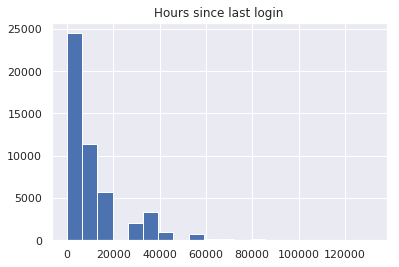

In [18]:
fig5 = plt.hist(df.hoursSinceLogin, log = False, bins = 20)
plt.title('Hours since last login')

### How did users spread across the globe? For each country, find the average account age.

In [19]:
#countrySummaries = df.groupby('currentCountry').median().joinDate.sort_values()
#countrySummaries
#
#df.boxplot(by = 'currentCountry')
#
#df.boxplot(column='joinDate', by='currentCountry', figsize=(14,8), rot = 45)
#g = sns.catplot('currentCountry', 'joinDate', data=df , kind='box', height=10)
#plt.xticks(rotation=-45)
#plt.ylim(2003, 2019)

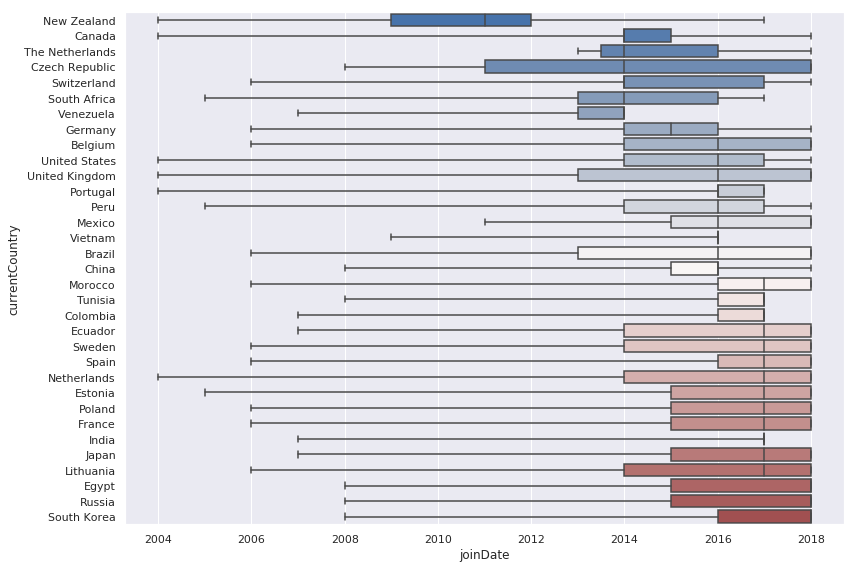

In [25]:
ordering = df[df.currentCountry!="Nan"].groupby('currentCountry').joinDate.median()
ordering.sort_values()

plt.figure(figsize=(12,8))

sns.boxplot(x="joinDate", y="currentCountry",
            data=df[df.currentCountry!="Nan"],
            whis="range", palette="vlag",
            order=ordering.sort_values().index)
plt.tight_layout()
plt.savefig('csSpread.svg')

In [32]:
#pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
#g = sns.FacetGrid(df[(df.age>0) & (df.age < 122)], row="joinDate", aspect=15, height=3, palette=pal)

#g.map(sns.kdeplot, "joinAge", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
#g.map(sns.kdeplot, "joinAge", clip_on=False, color="w", lw=2, bw=.2)
#g.map(plt.axhline, y=0, lw=2, clip_on=False)
#plt.title("Age of Users when they joined")
#sns.kdeplot(data=df.age[df.age>0])

In [33]:
#df_reduced = df[['nRefs','couchStatus','user_url', 'nFriends', 'nLanguages', 'age', 'joinDate', 'profileCompletion']]
#sns.pairplot(df_reduced, hue='couchStatus', size = 2.5)

## How much are these users engaging overall?

Ratio of users with 5% or less of a profile: 0.2033812307192726
Ratio of users with 10% or less of a profile: 0.44713021594414676
Ratio of users with 15% or less of a profile: 0.5215741191751908
Ratio of users with 40% or more of a profile: 0.36450722519889595


<Figure size 864x576 with 0 Axes>

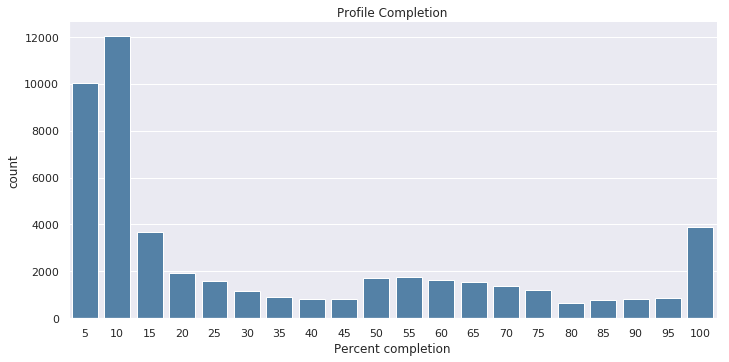

In [33]:
#fig5 = plt.hist(df.profileCompletion, bins = 20)
plt.figure(figsize=(12,8))
sns.catplot("profileCompletion", data=df, kind = 'count', color = 'steelblue', height = 5, aspect=2)
#sns.color_palette("Reds")
plt.title('Profile Completion')
plt.xlabel("Percent completion")
# Since filling in name and email address gives you 5%, anyone not exceeding this threshold hasn't done more than the minimum
#plt.hist(df.profileCompletion[df.profileCompletion>5], bins = 19)
print("Ratio of users with 5% or less of a profile: " + str(sum(df.profileCompletion<=5)/len(df.profileCompletion)))
print("Ratio of users with 10% or less of a profile: " + str(sum(df.profileCompletion<=10)/len(df.profileCompletion)))
print("Ratio of users with 15% or less of a profile: " + str(sum(df.profileCompletion<=15)/len(df.profileCompletion)))
print("Ratio of users with 40% or more of a profile: " + str(sum(df.profileCompletion>=40)/len(df.profileCompletion)))
plt.savefig('profileCompletion.png')

### Give them a chance- maybe they haven't gotten around to filling out profiles

Ratio of users with  5% or less of a profile: 0.19642630201052283
Ratio of users with 10% or less of a profile: 0.4198968050224945
Ratio of users with 15% or less of a profile: 0.49241288157995067
Ratio of users with 40% or more of a profile: 0.39117505019952725


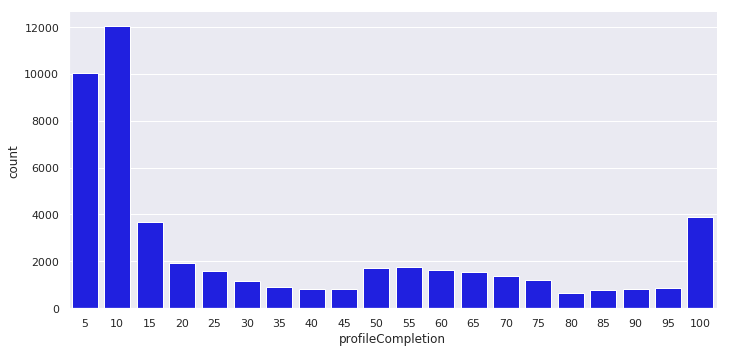

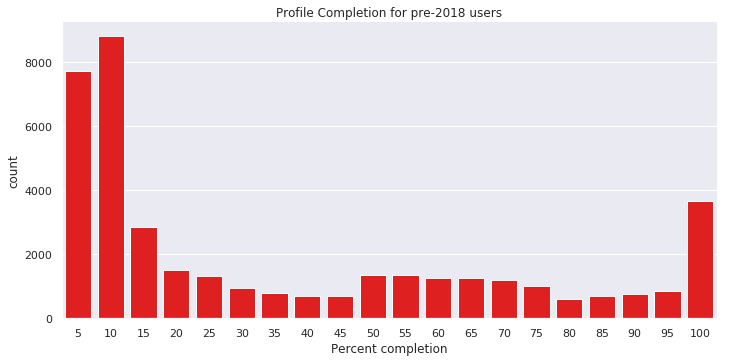

In [50]:
# Profile completion for users who created accounts in 2017 or earlier?
oldUsers = df.loc[df.joinDate <= 2017,:]
sns.catplot("profileCompletion", data=df, kind = 'count', color = 'blue', aspect=2)
sns.catplot("profileCompletion", data=oldUsers, kind = 'count', color = 'red', aspect=2)
# fig5 = plt.hist(oldUsers.profileCompletion, bins = 20)
plt.title('Profile Completion for pre-2018 users')
plt.xlabel("Percent completion")
print("Ratio of users with  5% or less of a profile: " + str(sum(oldUsers.profileCompletion<=5)/len(oldUsers.profileCompletion)))
print("Ratio of users with 10% or less of a profile: " + str(sum(oldUsers.profileCompletion<=10)/len(oldUsers.profileCompletion)))
print("Ratio of users with 15% or less of a profile: " + str(sum(oldUsers.profileCompletion<=15)/len(oldUsers.profileCompletion)))
print("Ratio of users with 40% or more of a profile: " + str(sum(oldUsers.profileCompletion>=40)/len(oldUsers.profileCompletion)))

### Apparently there's not much of a difference. Most people join and never complete their profiles.

In [36]:
#pd.crosstab(index = df.nRefs, columns = df.nFriends)

## From now on, let's only look at users who have 40% of a profile and have signed in within the last year, signaling they have a serious intention to use the service

In [42]:
Active_df = df.loc[(df.profileCompletion > 40) & (df.hoursSinceLogin < 8760), :]

Percent of males accepting guests: 39%
Percent of females accepting guests: 19%


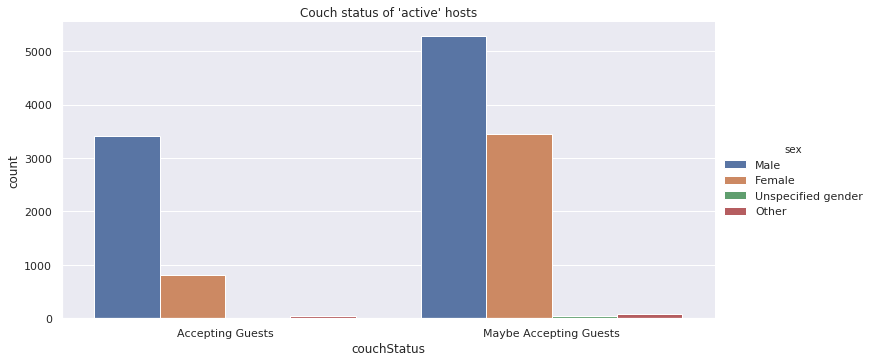

In [43]:
g = sns.catplot(x = "couchStatus", hue = "sex", data=Active_df[(Active_df.couchStatus=="Accepting Guests") | (Active_df.couchStatus=="Maybe Accepting Guests")], kind='count', aspect=2)
plt.title("Couch status of 'active' hosts")

totalMales = len(Active_df[Active_df.sex=="Male"])
totalFemales = len(Active_df[Active_df.sex=="Female"])
hostingMales = len(Active_df[(Active_df.sex=="Male") & (Active_df.couchStatus=="Accepting Guests")])
hostingFemales = len(Active_df[(Active_df.sex=="Female") & (Active_df.couchStatus=="Accepting Guests")])


print("Percent of males accepting guests: " + str(round(100 * hostingMales/totalMales)) + "%")
print("Percent of females accepting guests: " + str(round(100 * hostingFemales/totalFemales)) + "%")

In [44]:
#g = sns.catplot(x = "couchStatus", hue = "sex", data=Active_df, kind='count', aspect=2)
#plt.title("Couch status of 'active' hosts in the U.S.")
#
#
#totalMales = len(Active_df[(Active_df.sex=="Male") & (Active_df.currentCountry=='United States')])
#totalFemales = len(Active_df[(Active_df.sex=="Female") & (Active_df.currentCountry=='United States')])
#hostingMales = len(Active_df[(Active_df.sex=="Male") & (Active_df.couchStatus=="Accepting Guests") & (Active_df.currentCountry=='United States')])
#hostingFemales = len(Active_df[(Active_df.sex=="Female") & (Active_df.couchStatus=="Accepting Guests") & (Active_df.currentCountry=='United States')])
#
#
#print("Percent of American males accepting guests: " + str(round(100 * hostingMales/totalMales)) + "%")
#print("Percent of American females accepting guests: " + str(round(100 * hostingFemales/totalFemales)) + "%")

In [45]:
#g = sns.catplot(x="age", hue="couchStatus", data=Active_df[Active_df.age < 70], kind='count', aspect = 2)
#plt.title("Couch status by age")
#df.groupby('couchStatus').median()

20

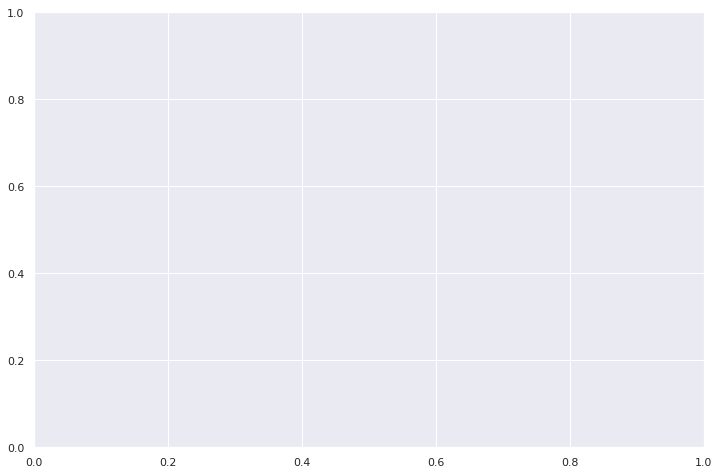

In [77]:
#plt.figure(figsize=(12,8))

Active_accepting = Active_df[(Active_df.age < 70) & (Active_df.couchStatus == "Accepting Guests")].groupby(by = 'age').count().couchStatus
Active_maybe = Active_df[(Active_df.age < 70) & (Active_df.couchStatus == "Maybe Accepting Guests")].groupby(by = 'age').count().couchStatus

sns.barplot(x = 'age', y = 'couchStatus', data = Active_accepting)
Active_maybe[0]

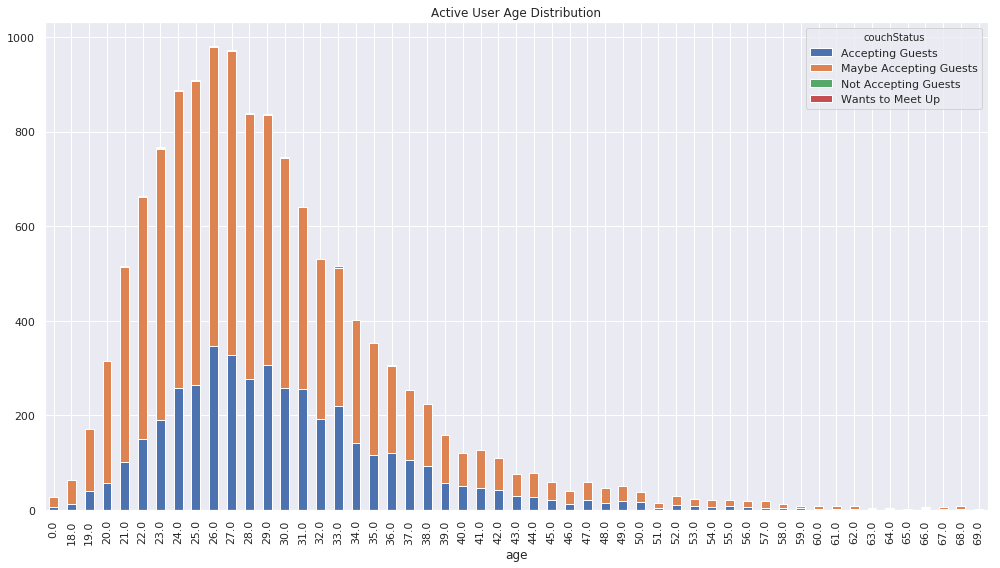

In [91]:
#plt.figure(figsize=(12,8))
plt.rcParams['figure.figsize']=(14,8)
Active_df[Active_df.age < 70].groupby(['age','couchStatus']).size().unstack().plot(kind='bar',stacked=True)
plt.title('Active User Age Distribution')
plt.tight_layout()
plt.savefig("AgeDist.png")

Ratio of users with zero references: 0.8574979859592589


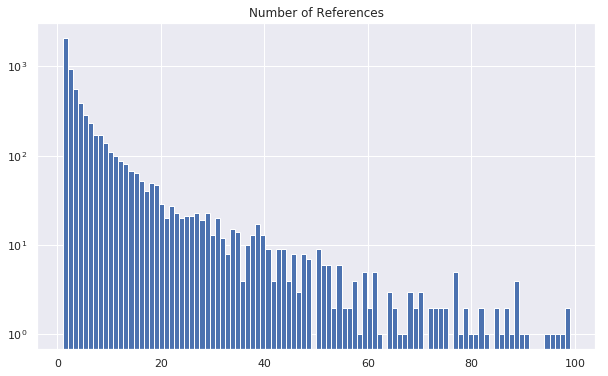

In [66]:
#g = sns.catplot(x='nRefs', data=df[df.nRefs>0], kind='count')
fig2 = plt.hist(df.nRefs[(df.nRefs>0) & (df.nRefs < 100)], log = True, bins = 100)
plt.title('Number of References')
#plt.xlim(0,30)
print("Ratio of users with zero references: " + str(sum(df.nRefs==0)/len(df.nRefs)))

(-1.103930821680024,
 1.100187186806533,
 -1.1072364191530042,
 1.1065068887490261)

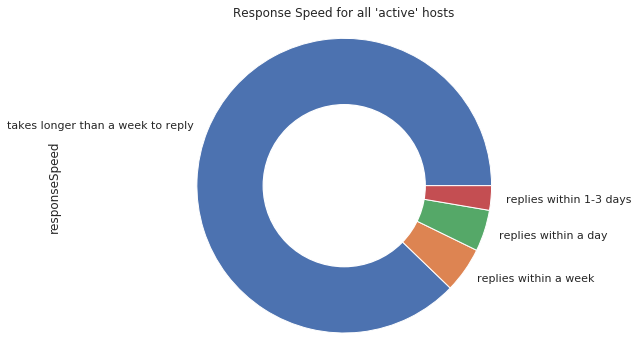

In [61]:
Active_df['responseSpeed'].value_counts().plot(kind='pie')
plt.title("Response Speed for all 'active' hosts")

centre_circle = plt.Circle((0,0), 0.55, color='white', fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')

(-1.1057890153315724,
 1.1002756693856384,
 -1.106510296043345,
 1.1057782756092345)

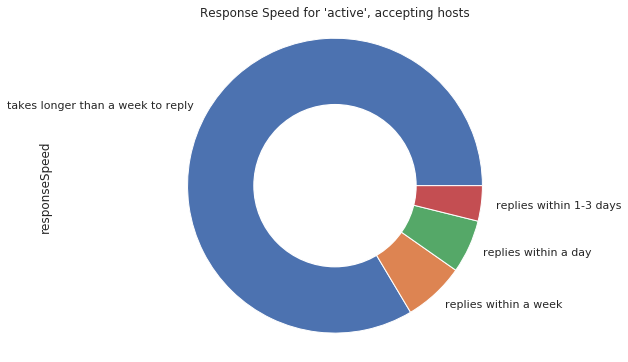

In [85]:
Active_df[Active_df.couchStatus=="Accepting Guests"].responseSpeed.value_counts().plot(kind='pie')
plt.title("Response Speed for 'active', accepting hosts")

centre_circle = plt.Circle((0,0), 0.55, color='white', fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')

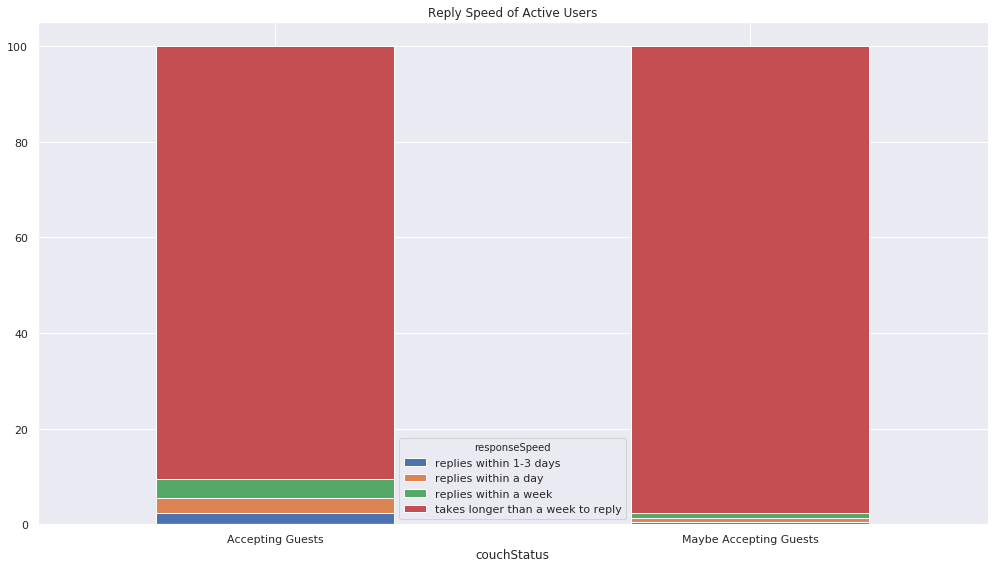

In [99]:
df[(df.couchStatus=='Accepting Guests') | (df.couchStatus=="Maybe Accepting Guests")].groupby(['couchStatus','responseSpeed']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True, rot = 0)
plt.title("Reply Speed of Active Users")
plt.tight_layout()
plt.savefig("ReplySpeed.png")

Text(0.5,1,'The Growth of Couchsurfing')

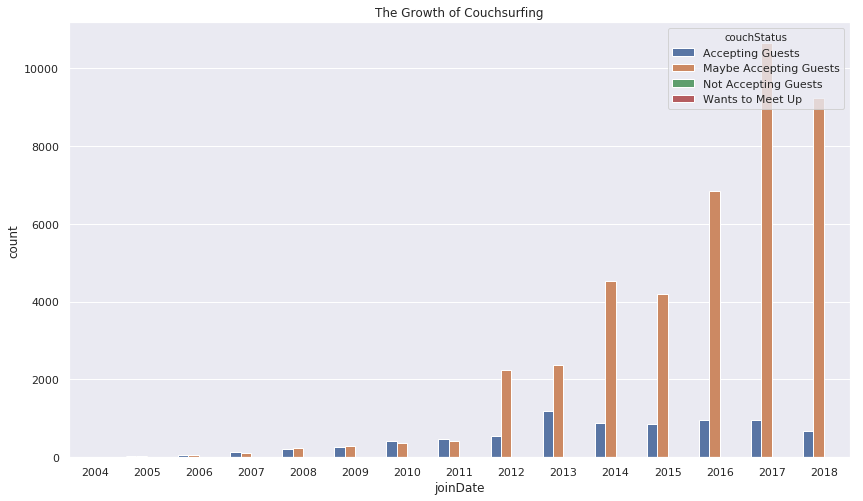

In [95]:
g = sns.countplot(x='joinDate', data = df, hue = 'couchStatus')


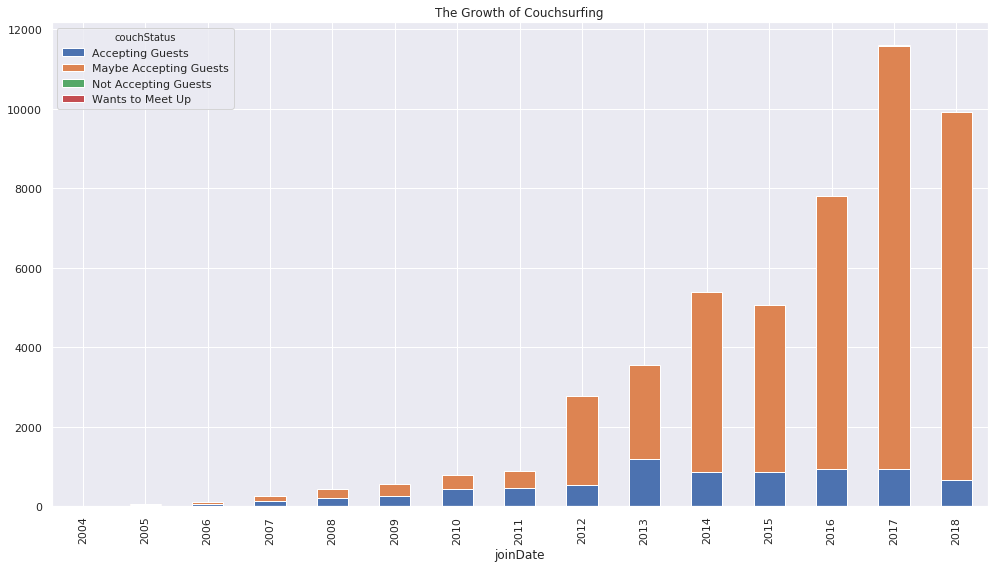

In [98]:
df.groupby(['joinDate','couchStatus']).size().unstack().plot(kind='bar',stacked=True)
plt.title("The Growth of Couchsurfing")
plt.tight_layout()
plt.savefig("CSGrowth.png")

In [42]:
#g = sns.countplot(x='joinDate', data = Active_df, hue = 'couchStatus')

Text(0,0.5,'Fraction of active hosts')

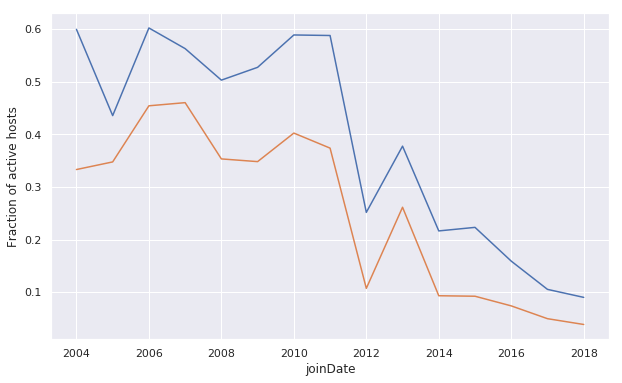

In [43]:
# For each year joined calculate the fraction of active hosts:
nMaleHostsPerYear = df[(df.couchStatus=='Accepting Guests') & (df.sex=="Male")].groupby('joinDate').agg('count').iloc[:,1]
nMaleUsersPerYear = df[df.sex=="Male"].groupby('joinDate').agg('count').iloc[:,0]
g = sns.lineplot(x= nMaleHostsPerYear.index, y=nMaleHostsPerYear/nMaleUsersPerYear)

nFemaleHostsPerYear = df[(df.couchStatus=='Accepting Guests') & (df.sex=="Female")].groupby('joinDate').agg('count').iloc[:,1]
nFemaleUsersPerYear = df[df.sex=="Female"].groupby('joinDate').agg('count').iloc[:,0]
g = sns.lineplot(x= nFemaleHostsPerYear.index, y=nFemaleHostsPerYear/nFemaleUsersPerYear)

plt.ylabel("Fraction of active hosts")

## How many active users are there?

Ratio of users with zero friends: 0.2792429885232196


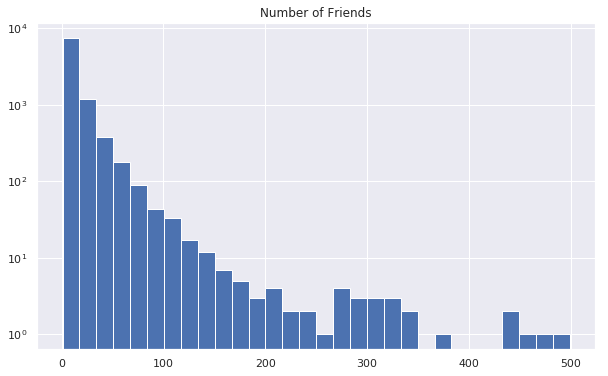

In [44]:
fig3 = plt.hist(Active_df.nFriends[(Active_df.nFriends>0) & (Active_df.nFriends<500)], log = True, bins = 30)
plt.title('Number of Friends')
print("Ratio of users with zero friends: " + str(sum(Active_df.nFriends==0)/len(Active_df.nFriends)))

Ratio of users with zero languages: 0.13384510146689976


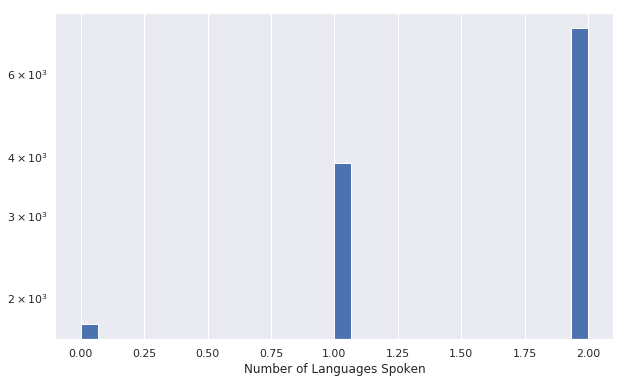

In [45]:
fig4 = plt.hist(Active_df.nLanguages, log = True, bins = 30)
plt.xlabel('Number of Languages Spoken')

print("Ratio of users with zero languages: " + str(sum(Active_df.nLanguages==0)/len(Active_df.nLanguages)))

## How is the number of non-engaging users changing over time?

## Let's consider very active users (those who have been active this month and have a reference)

In [60]:
veryActive_df = df.loc[(df.nRefs > 0) & (df.hoursSinceLogin < 720), :]

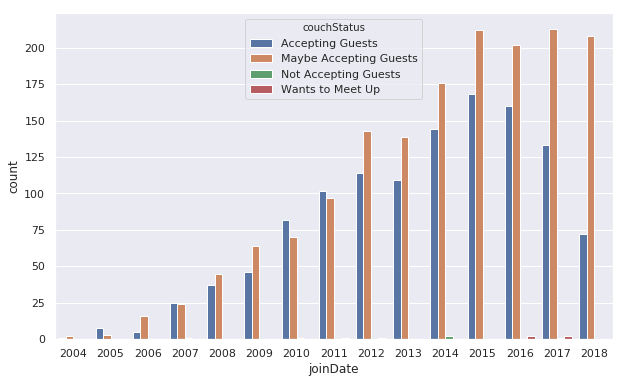

In [61]:
g = sns.countplot(x='joinDate', data = veryActive_df, hue = 'couchStatus')

Ratio of users with zero references: 0.0


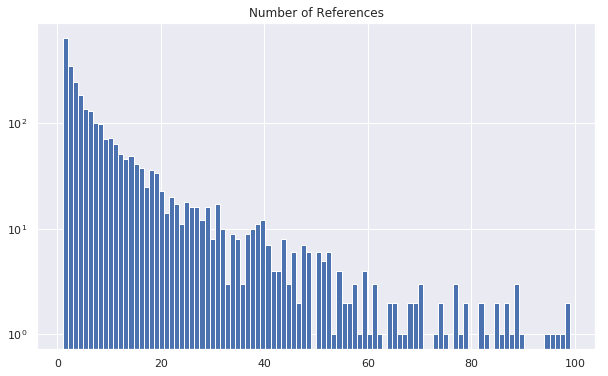

In [69]:
fig2 = plt.hist(veryActive_df.nRefs[(veryActive_df.nRefs>0) & (veryActive_df.nRefs < 100)], log = True, bins = 100)
plt.title('Number of References')
#plt.xlim(0,30)
print("Ratio of users with zero references: " + str(sum(veryActive_df.nRefs==0)/len(veryActive_df.nRefs)))

## Actionable insights?

### The site relies on the impression that 15 million hosts are available worldwide, while the real number is painfully low in comparison.